<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/Sakti_22_11_4677_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


Kode Advance Model dan EDA pada Graph Neural Network (GNN)
Menggunakan Dataset Cora dari PyTorch Geometric (Data berukuran kecil dan mudah diakses)

Dataset Cora:
Link Referensi: https://paperswithcode.com/dataset/cora
Atau dapat diakses langsung melalui PyTorch Geometric:
https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid

Kode ini memperlihatkan EDA sederhana (sebelum training) dan
implementasi model GNN (Graph Convolutional Network - GCN) dengan
arsitektur yang cukup lanjut (dua buah GCNConv + dropout + batch normalization).

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, BatchNorm
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [4]:
dataset_name = 'Cora'
dataset = Planetoid(root='data', name=dataset_name)

Processing...
Done!


In [5]:
data = dataset[0]

In [8]:
print("=== INFORMASI DATASET ===")
print(f"Nama Dataset        : {dataset_name}")
print(f"Jumlah Graph        : {len(dataset)}")
print(f"Fitur per Node      : {dataset.num_node_features}")
print(f"Jumlah Kelas        : {dataset.num_classes}")
print(f"Total Nodes         : {data.num_nodes}")
print(f"Total Edges         : {data.num_edges}")
print(f"Adakah Self-Loops?  : {data.has_self_loops()}")
print(f"Apakah Terhubung?   : {data.is_undirected()}")

=== INFORMASI DATASET ===
Nama Dataset        : Cora
Jumlah Graph        : 1
Fitur per Node      : 1433
Jumlah Kelas        : 7
Total Nodes         : 2708
Total Edges         : 10556
Adakah Self-Loops?  : False
Apakah Terhubung?   : True


In [7]:
print("=== INFO PEMBAGIAN DATA ===")
print(f"Train Mask (sum)    : {data.train_mask.sum().item()} nodes")
print(f"Validation Mask(sum): {data.val_mask.sum().item()} nodes")
print(f"Test Mask (sum)     : {data.test_mask.sum().item()} nodes")

=== INFO PEMBAGIAN DATA ===
Train Mask (sum)    : 140 nodes
Validation Mask(sum): 500 nodes
Test Mask (sum)     : 1000 nodes


In [9]:
labels, counts = torch.unique(data.y, return_counts=True)
print("=== DISTRIBUSI LABEL ===")
for label, count in zip(labels, counts):
    print(f"Class {int(label)} : {count.item()} nodes")

=== DISTRIBUSI LABEL ===
Class 0 : 351 nodes
Class 1 : 217 nodes
Class 2 : 418 nodes
Class 3 : 818 nodes
Class 4 : 426 nodes
Class 5 : 298 nodes
Class 6 : 180 nodes


In [10]:
class AdvancedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(AdvancedGCN, self).__init__()

        # Layer 1
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)

        # Layer 2
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)

        # Final Classification
        self.classifier = nn.Linear(hidden_channels, out_channels)

        # Dropout Rate
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Output
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdvancedGCN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print("Model & Data telah dipindahkan ke perangkat:", device)

Model & Data telah dipindahkan ke perangkat: cpu


In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    pred = out.argmax(dim=1)

    accs = []
    for mask_name, mask in zip(["Train", "Val", "Test"],
                               [data.train_mask, data.val_mask, data.test_mask]):
        correct = pred[mask].eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        acc = correct / total
        accs.append(acc)
    return accs

In [24]:
max_epochs = 200
train_losses = []
val_accs = []

for epoch in range(1, max_epochs + 1):
    loss = train()
    train_acc, val_acc, test_acc = test()

    train_losses.append(loss)
    val_accs.append(val_acc)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d} | Loss: {loss:.4f} "
              f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch: 020 | Loss: 0.0079 | Train Acc: 1.0000 | Val Acc: 0.6600 | Test Acc: 0.6610
Epoch: 040 | Loss: 0.0096 | Train Acc: 1.0000 | Val Acc: 0.6860 | Test Acc: 0.6800
Epoch: 060 | Loss: 0.0073 | Train Acc: 1.0000 | Val Acc: 0.6080 | Test Acc: 0.6560
Epoch: 080 | Loss: 0.0909 | Train Acc: 1.0000 | Val Acc: 0.6600 | Test Acc: 0.6950
Epoch: 100 | Loss: 0.0222 | Train Acc: 1.0000 | Val Acc: 0.6920 | Test Acc: 0.7200
Epoch: 120 | Loss: 0.0032 | Train Acc: 1.0000 | Val Acc: 0.6840 | Test Acc: 0.6800
Epoch: 140 | Loss: 0.0080 | Train Acc: 1.0000 | Val Acc: 0.7060 | Test Acc: 0.7190
Epoch: 160 | Loss: 0.0090 | Train Acc: 1.0000 | Val Acc: 0.7020 | Test Acc: 0.7150
Epoch: 180 | Loss: 0.0118 | Train Acc: 1.0000 | Val Acc: 0.7060 | Test Acc: 0.7220
Epoch: 200 | Loss: 0.0073 | Train Acc: 1.0000 | Val Acc: 0.7140 | Test Acc: 0.7310


In [25]:
train_acc, val_acc, test_acc = test()
print("\n=== HASIL EVALUASI AKHIR ===")
print(f"Final Train Accuracy : {train_acc:.4f}")
print(f"Final Val Accuracy   : {val_acc:.4f}")
print(f"Final Test Accuracy  : {test_acc:.4f}")


=== HASIL EVALUASI AKHIR ===
Final Train Accuracy : 1.0000
Final Val Accuracy   : 0.7140
Final Test Accuracy  : 0.7310


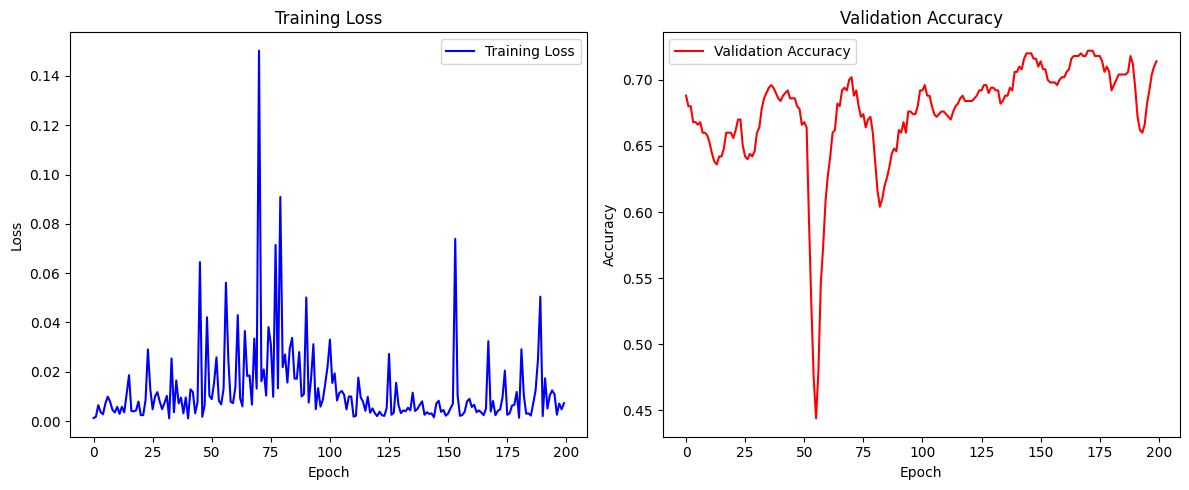

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()